In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn import preprocessing

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers

print(tf.__version__)


2.1.0


In [2]:
from data_processing import import_and_clean_train, label_encoding

train_X, test_X, train_y, test_y, labels_dict = import_and_clean_train('train', label_encoding)

{'Electrical': 1.0}


In [3]:
# Converting the data to arrays
train_X = np.array(train_X)
train_y = np.array(train_y)
test_X = np.array(test_X)
test_y = np.array(test_y)

Preprocessing: defining the normalizer and adapting it to the train set:

In [4]:
scaler = preprocessing.StandardScaler().fit(train_X)

train_X = scaler.transform(train_X)
test_X = scaler.transform(test_X)

Function to plot the loss (mean absolute error) at each epoch:

In [5]:
# function used in the train function to plot the cost of the model
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 200000])
    plt.xlabel('Epoch')
    plt.ylabel('Error [SalePrice]')
    plt.legend()
    plt.grid(True)
    plt.show()

# funtion to plot the prediction of the test data
def plot_predictions(model):
    test_predictions = model.predict(test_X).flatten()
    a = plt.axes(aspect='equal')
    plt.scatter(test_y, test_predictions)
    plt.xlabel('True Values [SalePrice]')
    plt.ylabel('Predictions [SalePrice]')
    lims = [0, 500000]
    plt.xlim(lims)
    plt.ylim(lims)
    _ = plt.plot(lims, lims)
    plt.show()

# funtion to plot the error distribution of the model
def plot_errors(model):
    test_predictions = model.predict(test_X).flatten()
    error = test_predictions - test_y
    plt.hist(error, bins=25)
    plt.xlabel('Prediction Error [SalePrice]')
    _ = plt.ylabel('Count')
    plt.show()


Function to train and evaluate a model which layers are defined outside it:

In [6]:
def train_and_evaluate(model, train_x, train_y, val_x, val_y, epochs=100):

    model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(0.001))

    history = model.fit(x=train_X, y=train_y, validation_data=(val_x, val_y), verbose=0, epochs=epochs)

    plot_loss(history)

    print(f"Train loss: {history.history['loss'][-1]}, val_loss {history.history['val_loss'][-1]}")

Preliminary model optimized on training loss:

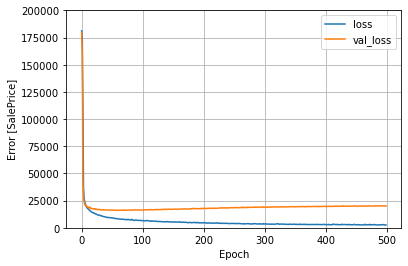

Train loss: 2573.9770417036143, val_loss 20013.17008686501


In [7]:
model = models.Sequential()
model.add(layers.Dense(79, activation='relu'))

model.add(layers.Dense(316, activation='relu'))
model.add(layers.Dense(237, activation='relu'))
model.add(layers.Dense(138, activation='relu'))

model.add(layers.Dense(1))

train_and_evaluate(model, train_X, train_y, test_X, test_y, epochs=500)

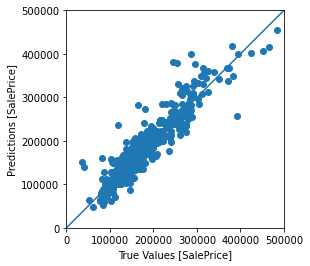

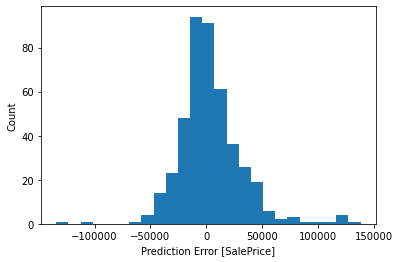

In [8]:
# Plotting the predictions of the test data based on the model
plot_predictions(model)
plot_errors(model)

Preliminary model optimized for vallidation loss:

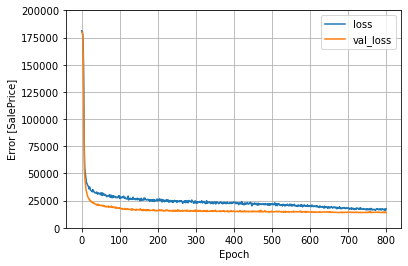

Train loss: 17414.00693340264, val_loss 14047.874108162101


In [9]:
model = models.Sequential()
model.add(layers.Dense(79, activation='relu',
                      kernel_regularizer=regularizers.l2(0.0001)))
model.add(layers.Dropout(.5))
model.add(layers.Dense(158, activation='relu',
                      kernel_regularizer=regularizers.l2(0.0001)))
model.add(layers.Dense(79, activation='relu',
                      kernel_regularizer=regularizers.l2(0.0001)))
model.add(layers.Dense(1))

train_and_evaluate(model, train_X, train_y, test_X, test_y, epochs=800)

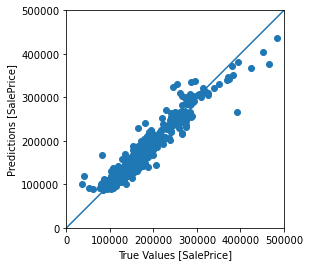

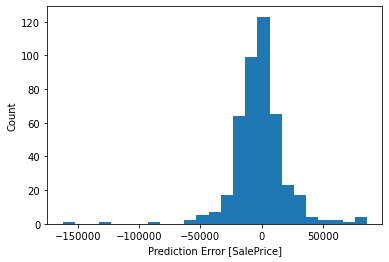

In [10]:
# Plotting the predictions of the test data based on the model
plot_predictions(model)
plot_errors(model)

Models for experimentation based on the architecture of the preliminary model:

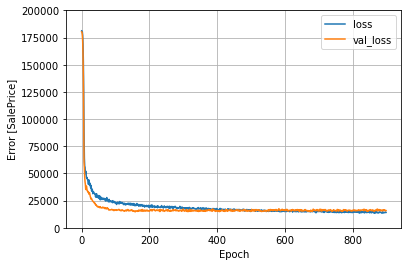

Train loss: 14084.444232739115, val_loss 15884.336062357306


In [11]:
model = models.Sequential()
model.add(layers.Dense(79, activation='relu', 
                       kernel_regularizer=regularizers.l2(0.0001)
                      ))
model.add(layers.Dropout(.5))

model.add(layers.Dense(316, activation='relu', 
                       kernel_regularizer=regularizers.l2(0.0001)
                      ))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(.5))

model.add(layers.Dense(237, activation='relu', 
                       kernel_regularizer=regularizers.l2(0.0001)
                      ))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(.2))

model.add(layers.Dense(138, activation='relu', 
                       kernel_regularizer=regularizers.l2(0.0001)
                      ))
# model.add(layers.BatchNormalization())
# model.add(layers.Dropout(.2))

model.add(layers.Dense(79, activation='relu',
                       kernel_regularizer=regularizers.l2(0.0001)
                      ))

model.add(layers.Dense(1))

train_and_evaluate(model, train_X, train_y, test_X, test_y, epochs=900)

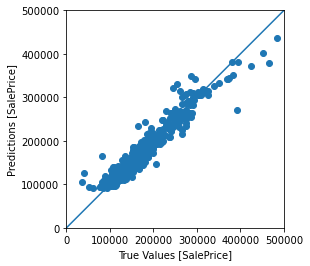

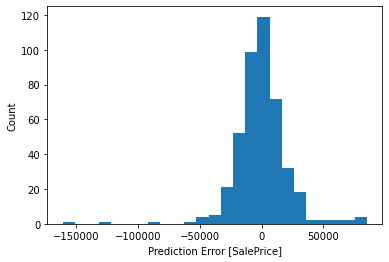

In [14]:
# Plotting the predictions of the test data based on the model
plot_predictions(model)
plot_errors(model)